In [1]:
import os
import polars as pl
import matplotlib.pyplot as plt

# Set up better visualization defaults
plt.style.use("seaborn-v0_8-whitegrid")
plt.rcParams["figure.figsize"] = (12, 8)
plt.rcParams["figure.dpi"] = 100

In [2]:
# Configuration - simplified constants
PROGRAM = "fib"
SIZE = 100000
PROJECTS = ["sp1", "risczero", "cairo-m", "noir-provekit", "miden"]

METRICS = {
    "proof_duration": {"title": "Prover Time", "unit": "s", "divisor": 1e9},
    "verify_duration": {"title": "Verifier Time", "unit": "ms", "divisor": 1e6},
    "proof_bytes": {"title": "Proof Size", "unit": "KB", "divisor": 1024},
}

PROJECT_COLORS = {
    "sp1": "#ff6b6b",
    "risczero": "#feca57",
    "cairo-m": "#5f27cd",
    "noir-provekit": "#222f3e",
    "miden": "#48dbfb",
}

In [3]:
def load_benchmark_data(data_dir="."):
    """Load benchmark data for the single program and all projects"""
    all_data = []

    for project in PROJECTS:
        filename = f"{PROGRAM}_{project}.csv"
        filepath = os.path.join(data_dir, filename)

        try:
            df = pl.read_csv(filepath)
            df = df.with_columns(
                [pl.lit(PROGRAM).alias("program"), pl.lit(project).alias("project")]
            )
            all_data.append(df)
        except FileNotFoundError:
            print(f"Warning: {filepath} not found, skipping.")

    if not all_data:
        raise ValueError("No benchmark data files found.")

    return pl.concat(all_data)

# Load the data
df = load_benchmark_data()
print(f"Loaded benchmark data with {df.height} entries")

Loaded benchmark data with 25 entries


In [4]:
def create_benchmark_comparison(df, metric_name):
    """Create a bar chart comparing projects for a specific metric"""
    if metric_name not in METRICS:
        raise ValueError(f"Unknown metric: {metric_name}")

    metric_info = METRICS[metric_name]
    title = f"{metric_info['title']} Comparison - {PROGRAM.upper()} (size={SIZE})"

    # Filter data for our program and size
    filtered_df = df.filter(
        (pl.col("program") == PROGRAM) & (pl.col("size") == SIZE)
    ).clone()

    if filtered_df.height == 0:
        print(f"No data for {PROGRAM} (size={SIZE})")
        return

    # Convert to appropriate units
    filtered_df = filtered_df.with_columns(
        (pl.col(metric_name) / metric_info["divisor"]).alias("converted_value")
    )

    # Create single plot
    plt.figure(figsize=(10, 6))

    # Get project colors
    projects = filtered_df["project"].to_list()
    colors = [PROJECT_COLORS.get(p, "#888888") for p in projects]
    values = filtered_df["converted_value"].to_list()

    # Create bar chart
    bars = plt.bar(projects, values, color=colors)

    # Add value labels on top of bars
    for bar, value in zip(bars, values):
        height = bar.get_height()
        formatted_value = f"{value:.1f}" if value < 10 else f"{int(value)}"
        plt.text(
            bar.get_x() + bar.get_width() / 2.0,
            height + 0.05 * height,
            formatted_value,
            ha="center",
            va="bottom",
            fontsize=10,
        )

    # Customize plot
    plt.title(title, fontsize=14)
    plt.ylabel(f"{metric_info['title']} ({metric_info['unit']})")
    plt.xticks(rotation=45)

    # Start y-axis at 0 unless values are very small
    min_value = filtered_df["converted_value"].min()
    if min_value > 0.1:
        plt.ylim(bottom=0)

    plt.tight_layout()
    plt.show()

In [5]:
def create_scaling_comparison(df, program, metric_name):
    """Create a line chart showing how a metric scales with input size for a specific program.

    Args:
        df (polars.DataFrame): Benchmark data
        program (str): Program to visualize
        metric_name (str): Name of the metric to visualize
    """
    if program != PROGRAM:
        raise ValueError(f"Unknown program: {program}")
    if metric_name not in METRICS:
        raise ValueError(f"Unknown metric: {metric_name}")

    metric_info = METRICS[metric_name]
    title = f"{program.upper()}: {metric_info['title']} Scaling by Input Size"

    # Filter data for this program
    program_df = df.filter(pl.col("program") == program).clone()

    if program_df.height == 0:
        print(f"No data available for {program}")
        return

    # Convert to appropriate units
    program_df = program_df.with_columns(
        (pl.col(metric_name) / metric_info["divisor"]).alias("converted_value")
    )

    # Create figure
    plt.figure(figsize=(12, 8))

    # For each project
    for project in PROJECTS:
        project_df = program_df.filter(pl.col("project") == project)

        if project_df.height == 0:
            continue

        # Sort by size for proper line plotting
        project_df = project_df.sort("size")

        sizes = project_df["size"].to_list()
        values = project_df["converted_value"].to_list()

        plt.plot(
            sizes,
            values,
            marker="o",
            linestyle="-",
            linewidth=2,
            color=PROJECT_COLORS.get(project, "#888888"),
            label=project,
        )

    # Customize plot
    plt.title(title, fontsize=16)
    plt.xlabel("Input Size", fontsize=12)
    plt.ylabel(f"{metric_info['title']} ({metric_info['unit']})", fontsize=12)
    plt.grid(True, alpha=0.3)
    plt.legend(fontsize=12)

    # Use log scales if range is large
    min_val = program_df["converted_value"].min()
    max_val = program_df["converted_value"].max()
    min_size = program_df["size"].min()
    max_size = program_df["size"].max()

    if max_val / min_val > 10:
        plt.yscale("log")
    if max_size / min_size > 10:
        plt.xscale("log")

    plt.tight_layout()
    plt.show()

In [6]:
def create_comparative_table(df):
    """Create a summary table with key metrics for all projects"""
    # Filter data for our program and size
    filtered_df = df.filter(
        (pl.col("program") == PROGRAM) & (pl.col("size") == SIZE)
    ).clone()

    if filtered_df.height == 0:
        print(f"No data for {PROGRAM} (size={SIZE})")
        return None

    # Create results list
    results = []

    for project in PROJECTS:
        project_data = filtered_df.filter(pl.col("project") == project)

        if project_data.height == 0:
            continue

        # Build row data
        row = {"Project": project}

        # Add each metric
        for metric, info in METRICS.items():
            if metric in project_data.columns:
                value = project_data[metric].item() / info["divisor"]
                row[f"{info['title']} ({info['unit']})"] = value

        results.append(row)

    # Convert to DataFrame and format
    if not results:
        print("No data available for summary table")
        return None

    results_df = pl.DataFrame(results)

    # Round numeric columns
    numeric_cols = [col for col in results_df.columns if col != "Project"]
    results_df = results_df.with_columns([pl.col(col).round(2) for col in numeric_cols])

    return results_df

Project,Prover Time (s),Verifier Time (ms),Proof Size (KB)
str,f64,f64,f64
"""sp1""",15.98,214.23,1757.61
"""risczero""",51.67,18.28,217.45
"""cairo-m""",1.74,3.37,58.4
"""noir-provekit""",5.79,10.27,338.32
"""miden""",3.93,0.85,96.3


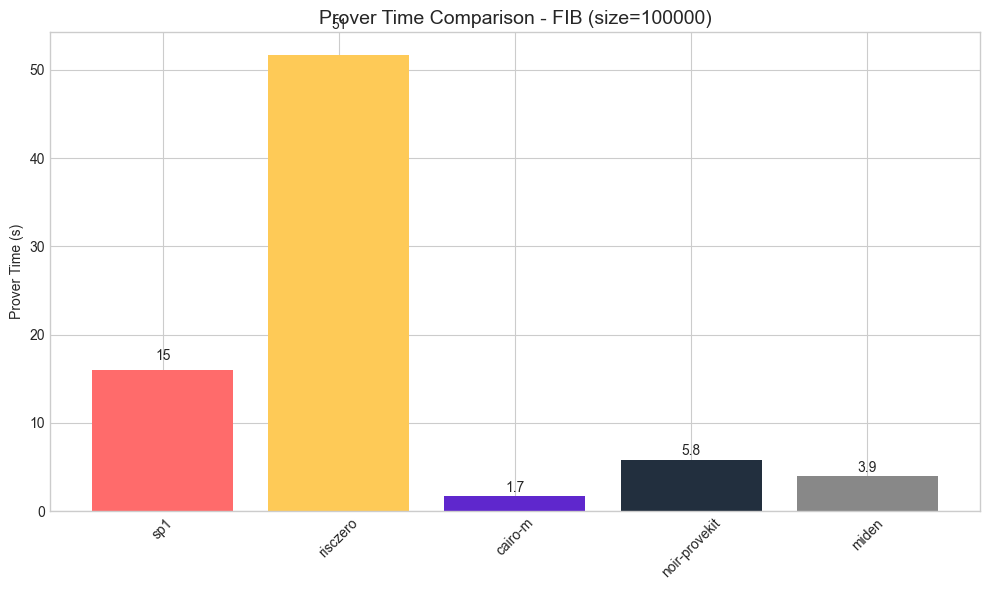

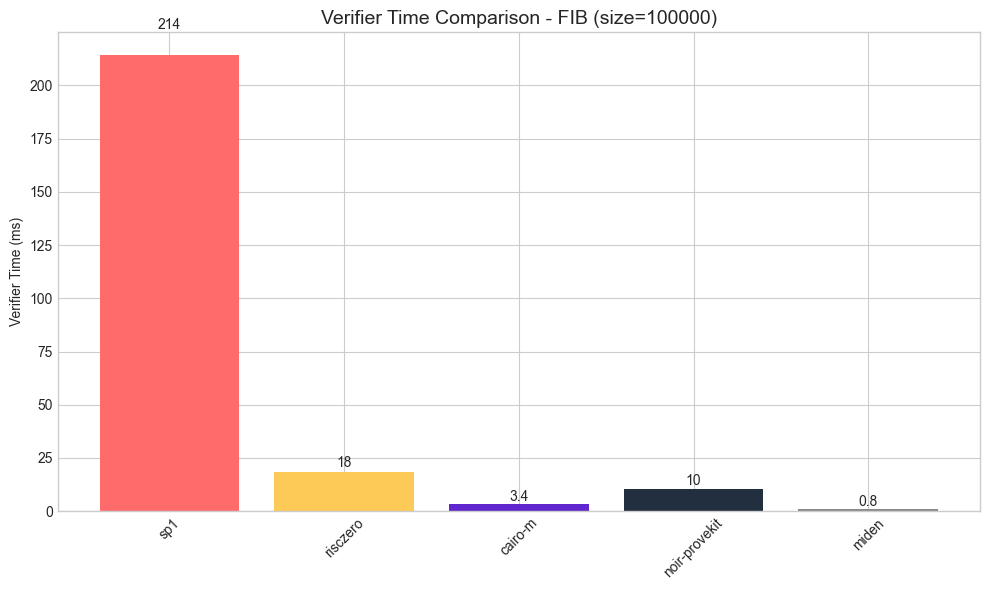

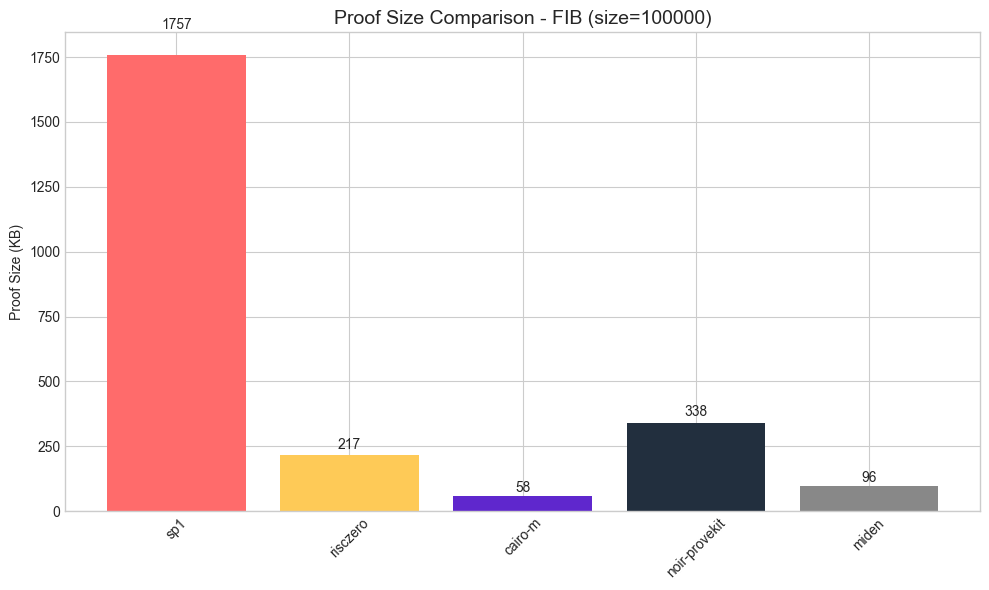

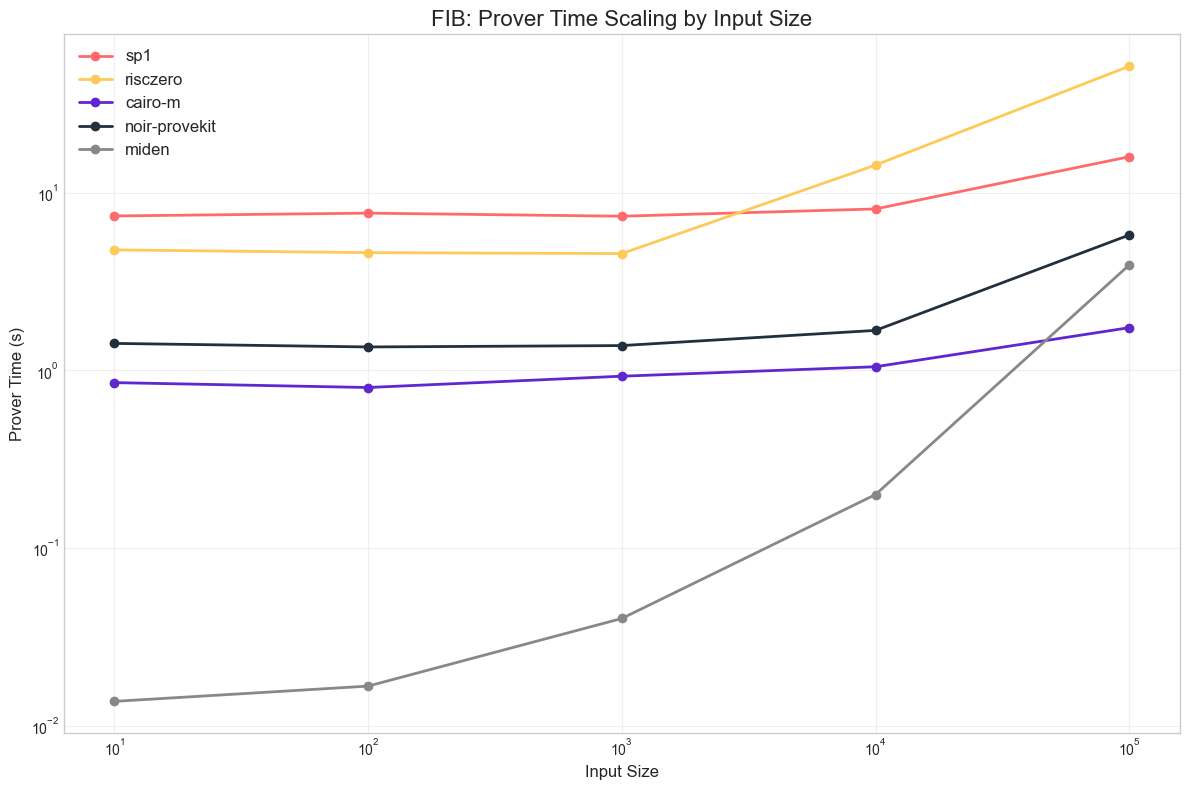

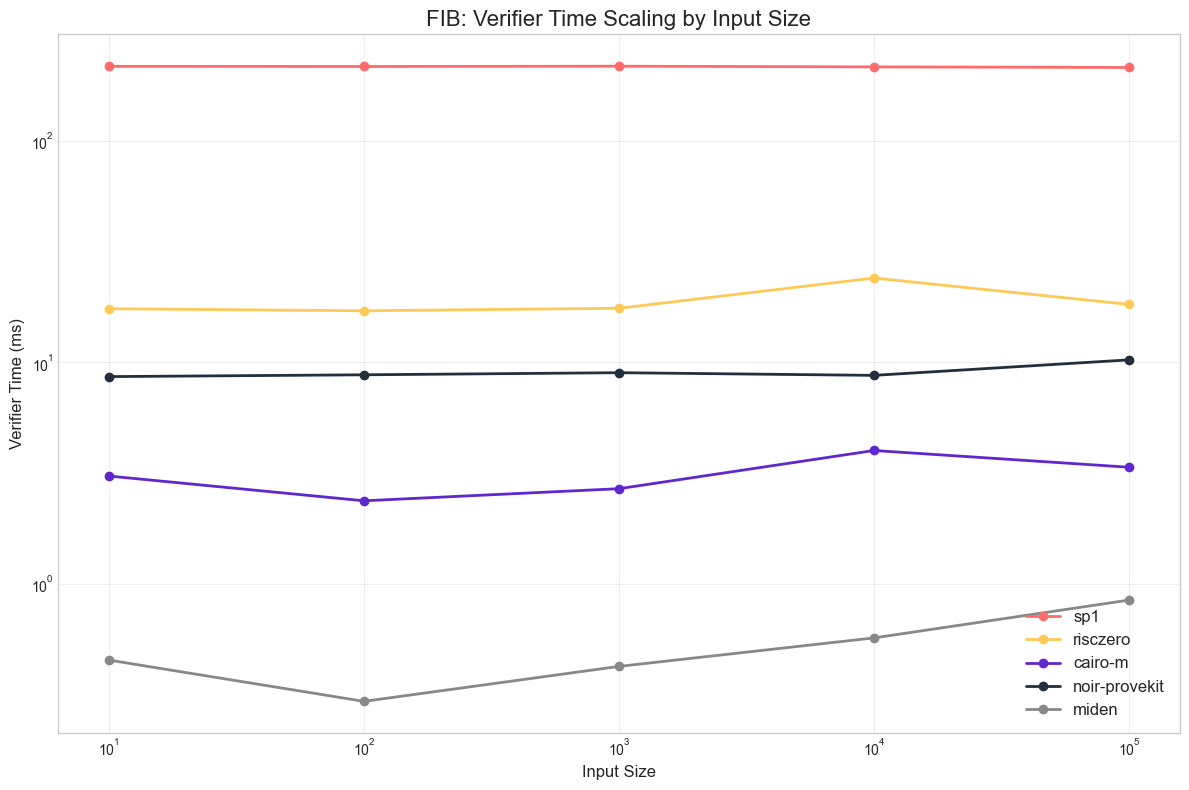

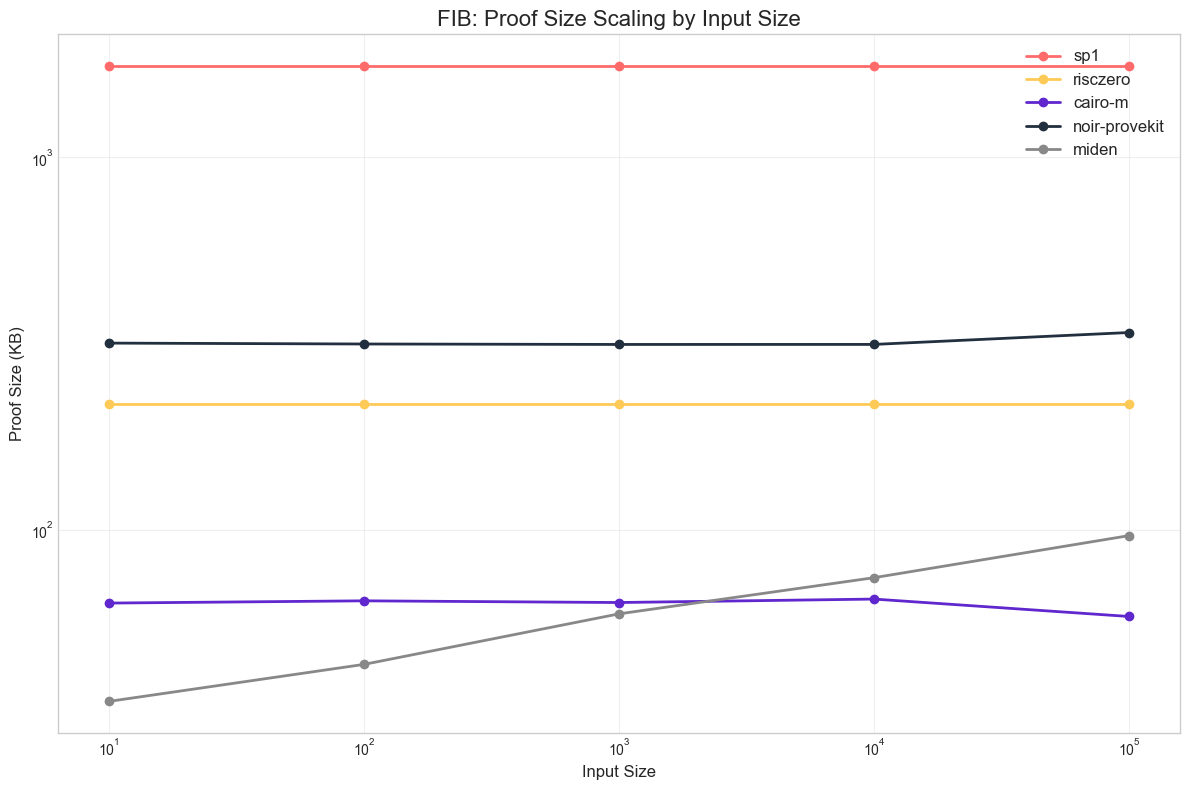

In [7]:
# Generate visualizations
display(create_comparative_table(df))
create_benchmark_comparison(df, "proof_duration")
create_benchmark_comparison(df, "verify_duration")
create_benchmark_comparison(df, "proof_bytes")
create_scaling_comparison(df, "fib", "proof_duration")
create_scaling_comparison(df, "fib", "verify_duration")
create_scaling_comparison(df, "fib", "proof_bytes")